In [1]:
%matplotlib inline


Object Detection Test
=====================


This demo will take you through the steps of running an "out-of-the-box" detection model on a
collection of images.



Create the data directory
~~~~~~~~~~~~~~~~~~~~~~~~~
The snippet shown below will create the ``data`` directory where all our data will be stored. The
code will create a directory structure as shown bellow:

.. code-block:: bash

    data
    ├── images
    └── models

where the ``images`` folder will contain the downlaoded test images, while ``models`` will
contain the downloaded models.



In [2]:
import os

DATA_DIR = os.path.join(os.getcwd(), 'data')
IMAGES_DIR = os.path.join(DATA_DIR, 'images')
MODELS_DIR = os.path.join(DATA_DIR, 'models')
for dir in [DATA_DIR, IMAGES_DIR, MODELS_DIR]:
    if not os.path.exists(dir):
        os.mkdir(dir)

Download the test images
~~~~~~~~~~~~~~~~~~~~~~~~
First we will download the images that we will use throughout this tutorial. The code snippet
shown bellow will download the test images from the `TensorFlow Model Garden <https://github.com/tensorflow/models/tree/master/research/object_detection/test_images>`_
and save them inside the ``data/images`` folder.



In [3]:
import urllib.request

IMAGE_FILENAMES = ['image1.jpg', 'image2.jpg']
IMAGES_DOWNLOAD_BASE = \
    'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/test_images/'

for image_filename in IMAGE_FILENAMES:

    image_path = os.path.join(IMAGES_DIR, image_filename)

    # Download image
    if not os.path.exists(image_path):
        print('Downloading {}... '.format(image_filename), end='')
        urllib.request.urlretrieve(IMAGES_DOWNLOAD_BASE + image_filename, image_path)
        print('Done')

Download the model
~~~~~~~~~~~~~~~~~~
The code snippet shown below is used to download the object detection model checkpoint file,
as well as the labels file (.pbtxt) which contains a list of strings used to add the correct
label to each detection (e.g. person). Once downloaded the files will be stored under the
``data/models`` folder.

The particular detection algorithm we will use is the `CenterNet HourGlass104 1024x1024`. More
models can be found in the `TensorFlow 2 Detection Model Zoo <https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md>`_.
To use a different model you will need the URL name of the specific model. This can be done as
follows:

1. Right click on the `Model name` of the model you would like to use;
2. Click on `Copy link address` to copy the download link of the model;
3. Paste the link in a text editor of your choice. You should observe a link similar to ``download.tensorflow.org/models/object_detection/tf2/YYYYYYYY/XXXXXXXXX.tar.gz``;
4. Copy the ``XXXXXXXXX`` part of the link and use it to replace the value of the ``MODEL_NAME`` variable in the code shown below;
5. Copy the ``YYYYYYYY`` part of the link and use it to replace the value of the ``MODEL_DATE`` variable in the code shown below.

For example, the download link for the model used below is: ``download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_1024x1024_coco17_tpu-32.tar.gz``



In [4]:
import tarfile

# Download and extract model
MODEL_DATE = '20200711'
MODEL_NAME = 'centernet_hg104_1024x1024_coco17_tpu-32'
MODEL_TAR_FILENAME = MODEL_NAME + '.tar.gz'
MODELS_DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/tf2/'
MODEL_DOWNLOAD_LINK = MODELS_DOWNLOAD_BASE + MODEL_DATE + '/' + MODEL_TAR_FILENAME
PATH_TO_MODEL_TAR = os.path.join(MODELS_DIR, MODEL_TAR_FILENAME)
PATH_TO_CKPT = os.path.join(MODELS_DIR, os.path.join(MODEL_NAME, 'checkpoint/'))
PATH_TO_CFG = os.path.join(MODELS_DIR, os.path.join(MODEL_NAME, 'pipeline.config'))
if not os.path.exists(PATH_TO_CKPT):
    print('Downloading model. This may take a while... ', end='')
    urllib.request.urlretrieve(MODEL_DOWNLOAD_LINK, PATH_TO_MODEL_TAR)
    tar_file = tarfile.open(PATH_TO_MODEL_TAR)
    tar_file.extractall(MODELS_DIR)
    tar_file.close()
    os.remove(PATH_TO_MODEL_TAR)
    print('Done')

# Download labels file
LABEL_FILENAME = 'mscoco_label_map.pbtxt'
LABELS_DOWNLOAD_BASE = \
    'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/'
PATH_TO_LABELS = os.path.join(MODELS_DIR, os.path.join(MODEL_NAME, LABEL_FILENAME))
if not os.path.exists(PATH_TO_LABELS):
    print('Downloading label file... ', end='')
    urllib.request.urlretrieve(LABELS_DOWNLOAD_BASE + LABEL_FILENAME, PATH_TO_LABELS)
    print('Done')

Load the model
~~~~~~~~~~~~~~
Next we load the downloaded model



In [5]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()

@tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

Load label map data (for plotting)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Label maps correspond index numbers to category names, so that when our convolution network
predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility
functions, but anything that returns a dictionary mapping integers to appropriate string labels
would be fine.



In [6]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

Putting everything together
~~~~~~~~~~~~~~~~~~~~~~~~~~~
The code shown below loads an image, runs it through the detection model and visualizes the
detection results, including the keypoints.

Note that this will take a long time (several minutes) the first time you run this code due to
tf.function's trace-compilation --- on subsequent runs (e.g. on new images), things will be
faster.

Here are some simple things to try out if you are curious:

* Modify some of the input images and see if detection still works. Some simple things to try out here (just uncomment the relevant portions of code) include flipping the image horizontally, or converting to grayscale (note that we still expect the input image to have 3 channels).
* Print out `detections['detection_boxes']` and try to match the box locations to the boxes in the image.  Notice that coordinates are given in normalized form (i.e., in the interval [0, 1]).
* Set ``min_score_thresh`` to other values (between 0 and 1) to allow more detections in or to filter out more detections.



In [8]:
%matplotlib inline

Running inference for image1.jpg... Done
Running inference for image2.jpg... Done


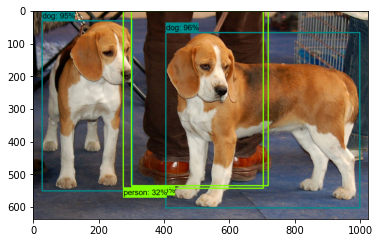

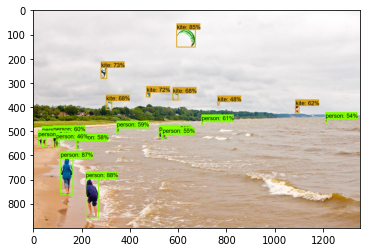

In [9]:
import numpy as np
from six import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


for image_filename in IMAGE_FILENAMES:

    print('Running inference for {}... '.format(image_filename), end='')

    image_path = os.path.join(IMAGES_DIR, image_filename)
    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    input_tensor = tf.convert_to_tensor(
        np.expand_dims(image_np, 0), dtype=tf.float32)
    detections, predictions_dict, shapes = detect_fn(input_tensor)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'][0].numpy(),
          (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
          detections['detection_scores'][0].numpy(),
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()

# sphinx_gallery_thumbnail_number = 2